In [15]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

In [54]:
import sklearn

sklearn.set_config(display="diagram")

In [2]:
diabetes_df = load_diabetes(as_frame=True)

In [4]:
y = diabetes_df.target
X = diabetes_df.data

In [5]:
y.isnull().sum()

0

In [6]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [9]:
print(diabetes_df.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [10]:
X.isnull().sum()


age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

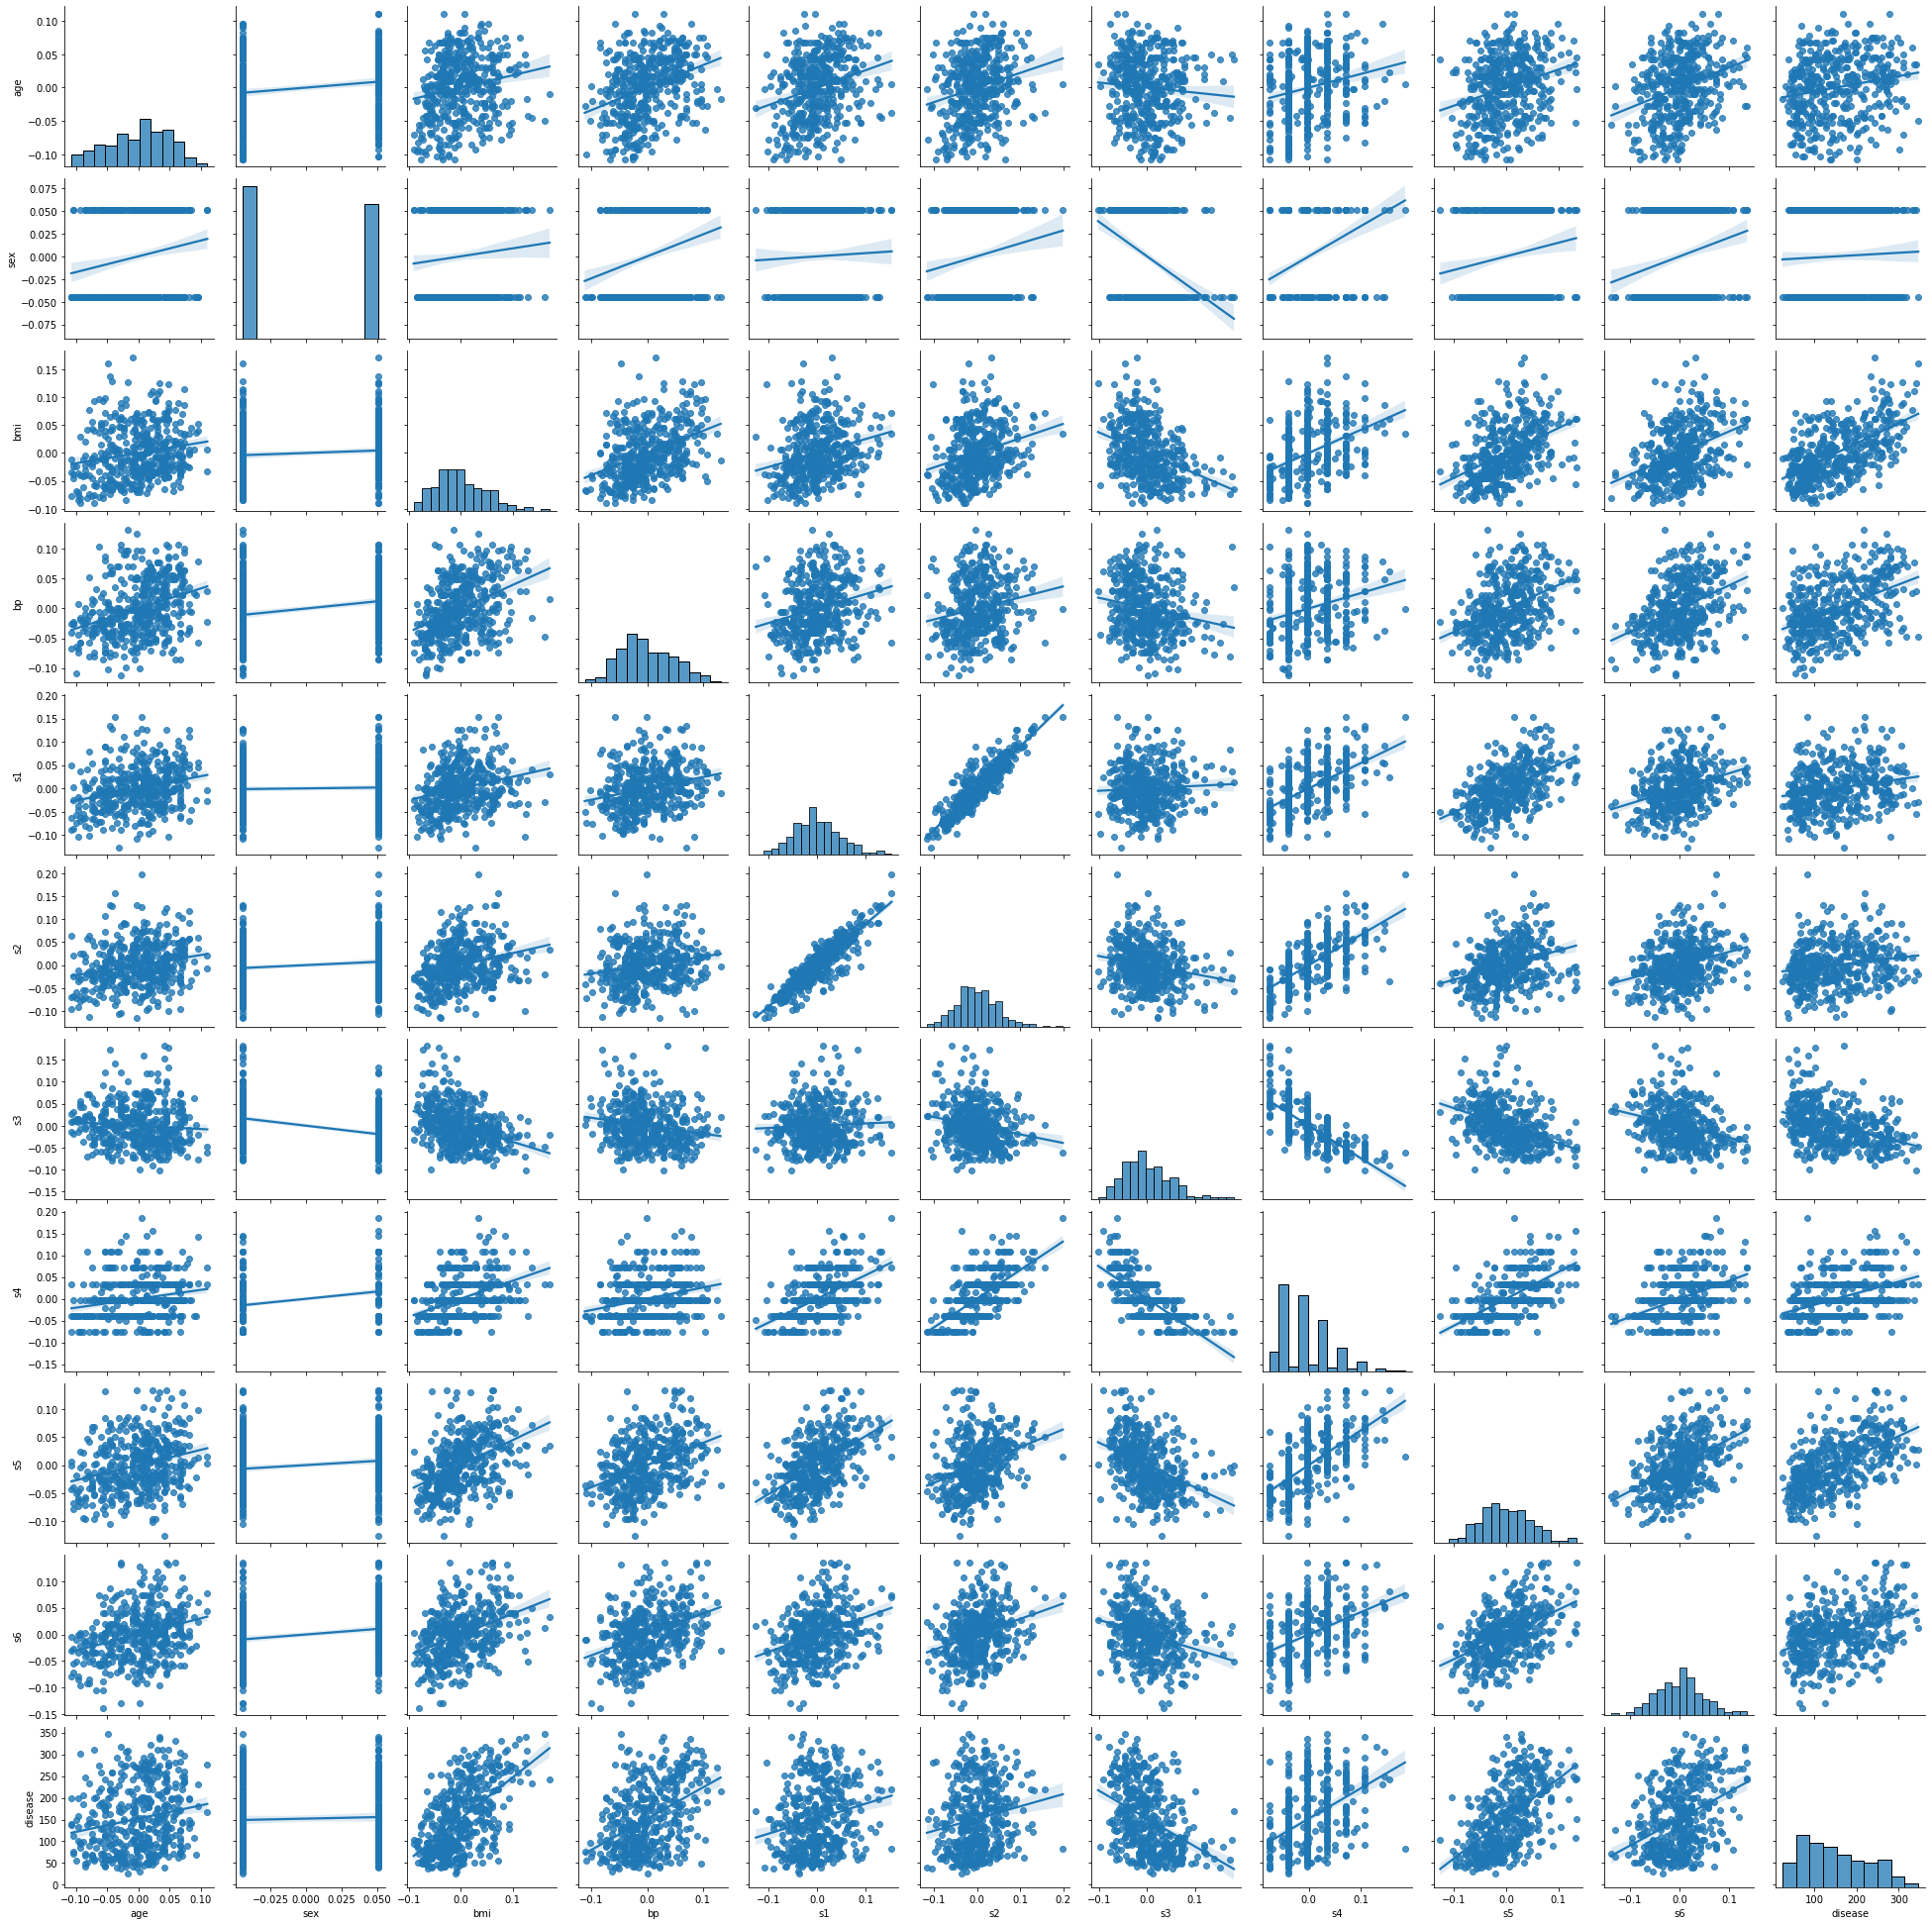

In [11]:
data_df = X.copy()
data_df['disease'] = y

import seaborn as sns
sns.pairplot(data_df, kind="reg")

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train, y_train)

In [34]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=np.logspace(-10, 10, 21), max_iter=100000, cv=20)
lasso_model.fit(X_train_scaled, y_train)

LassoCV(alphas=array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10]),
        cv=20, max_iter=100000)

In [35]:
lasso_model.alpha_

0.1

In [36]:
from sklearn.metrics import mean_squared_error

X_test_scaled = sc.transform(X_test)
y_test_pred = lasso_model.predict(X_test_scaled)
mean_squared_error(y_test, y_test_pred, squared=False)

53.7764851926115

<AxesSubplot:>

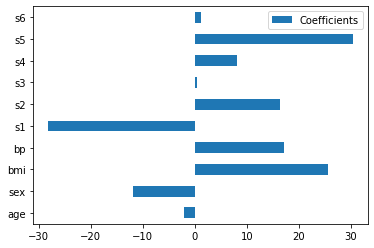

In [37]:
coef_names = X.columns
coefficients = pd.DataFrame(data=lasso_model.coef_, index=coef_names, columns=["Coefficients"])
coefficients.plot(kind="barh")

<AxesSubplot:>

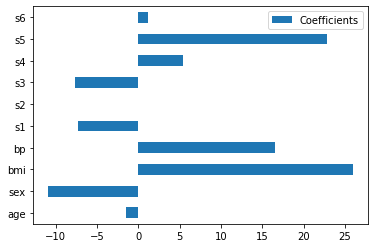

In [38]:
# Experiment with very strong regularization
from sklearn.linear_model import Lasso
lasso_model_reg = Lasso(alpha=0.5)
lasso_model_reg.fit(X_train_scaled, y_train)

y_test_pred = lasso_model_reg.predict(X_test_scaled)
mean_squared_error(y_test, y_test_pred, squared=False)

coefficients = pd.DataFrame(data=lasso_model_reg.coef_, index=coef_names, columns=["Coefficients"])
coefficients.plot(kind="barh")

In [57]:
# Extract AIC criterion
from sklearn.linear_model import LassoLarsIC
lasso_aic = LassoLarsIC(criterion="aic", normalize=False)
lasso_aic.fit(X_train_scaled, y_train)

# Store value of alpha and AIC criterion for each iteration
aic_df = pd.DataFrame(
    {
        "alphas": lasso_aic.alphas_,
        "AIC_criterion": lasso_aic.criterion_
    }
).set_index("alphas")

In [63]:
# Extract BIC criterion
from sklearn.linear_model import LassoLarsIC
lasso_bic = LassoLarsIC(criterion="bic", normalize=False)
lasso_bic.fit(X_train_scaled, y_train)

# Store value of alpha and AIC criterion for each iteration
bic_df = pd.DataFrame(
    {
        "alphas": lasso_bic.alphas_,
        "BIC_criterion": lasso_bic.criterion_
    }
).set_index("alphas")


In [64]:
result = pd.DataFrame(
    {
        "alphas": lasso_bic.alphas_,
        "AIC": aic_df.AIC_criterion,
        "BIC": bic_df.BIC_criterion
}
).set_index("alphas")

In [65]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]


result.style.apply(highlight_min)


,AIC,BIC
alphas,,
45.01369714473897,331.000000,331.000000
37.395340662714375,297.419681,301.221799
23.383751709426704,230.699619,238.303855
14.01612690409386,199.655655,211.062010
6.170707091744739,183.875242,199.083715
2.5320415700734094,177.046633,196.057225
1.8969629165155213,177.830238,200.642948
1.8644144900702284,179.773852,206.388680
1.2263810268075936,180.731045,211.147992


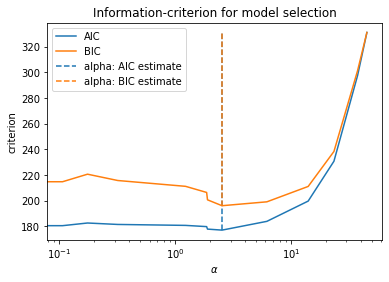

In [66]:
ax = result.plot()
ax.vlines(
    lasso_aic.alpha_,
    result["AIC"].min(),
    result["AIC"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    lasso_bic.alpha_,
    result["BIC"].min(),
    result["BIC"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection"
)